In [ ]:
# --- Core imports ---
import os, random, pickle, time
import numpy as np
import tensorflow as tf
from pathlib import Path

# --- Keras imports ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, EfficientNetB0
)
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

# --- GPU setup ---
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print("✅ GPU detected and configured.")
else:
    print("⚠️ No GPU detected — training may be slow.")

random.seed(42)


⚠️ No GPU detected — training may be slow.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Adjust path if needed
dataset_root = Path("/content/drive/MyDrive/24_images")
train_dir = dataset_root / "train"
val_dir   = dataset_root / "test"

print("Train:", train_dir)
print("Test :", val_dir)

assert train_dir.exists(), f"❌ Train folder not found: {train_dir}"
assert val_dir.exists(), f"❌ Test folder not found: {val_dir}"

train_count = sum(len(f) for _,_,f in os.walk(train_dir))
val_count   = sum(len(f) for _,_,f in os.walk(val_dir))
print(f"✅ Dataset OK — Train: {train_count},  Test: {val_count}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train: /content/drive/MyDrive/24_images/train
Test : /content/drive/MyDrive/24_images/test
✅ Dataset OK — Train: 168,  Test: 168


In [ ]:
BATCH_SIZE = 8

MODEL_SPECS = {
    "VGG16": {"base": VGG16, "target_hw": (224, 224), "preprocess": vgg_preprocess},
    "ResNet50": {"base": ResNet50, "target_hw": (224, 224), "preprocess": resnet_preprocess},
    "InceptionV3": {"base": InceptionV3, "target_hw": (299, 299), "preprocess": inception_preprocess},
    "EfficientNetB0": {"base": EfficientNetB0, "target_hw": (224, 224), "preprocess": effnet_preprocess},
}


In [ ]:
# Create data generators per model
def make_datagens(preprocess_fn):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    return train_datagen, val_datagen


# Build CNN model for each backbone — clean, NO Lambda layers
def build_emotion_model(name, num_classes):
    spec = MODEL_SPECS[name]
    target_h, target_w = spec["target_hw"]
    base_cls = spec["base"]

    inp = Input(shape=(target_h, target_w, 3), name=f"{name}_input")
    base_model = base_cls(weights="imagenet", include_top=False, input_tensor=inp)
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=out, name=f"{name}_emotion_model")
    return model


In [ ]:
save_dir = Path("/content/drive/MyDrive/EmotionDetection_Trained")
save_dir.mkdir(parents=True, exist_ok=True)

for name, spec in MODEL_SPECS.items():
    print(f"\n==============================")
    print(f"Training {name} model")
    print(f"==============================")

    preprocess_fn = spec["preprocess"]
    target_h, target_w = spec["target_hw"]

    train_datagen, val_datagen = make_datagens(preprocess_fn)

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=(target_h, target_w),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True
    )

    val_data = val_datagen.flow_from_directory(
        val_dir,
        target_size=(target_h, target_w),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    num_classes = len(train_data.class_indices)
    emotion_labels = list(train_data.class_indices.keys())

    model = build_emotion_model(name, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss="categorical_crossentropy", metrics=["accuracy"])

    start = time.time()
    model.fit(train_data, validation_data=val_data, epochs=3, verbose=1)
    print(f"⏱ Training time: {(time.time()-start):.2f} sec")

    model_path = save_dir / f"{name}_emotion_model.keras"
    model.save(model_path)
    print(f"💾 Saved model: {model_path}")

    metadata = {
        "model_name": name,
        "emotion_labels": emotion_labels,
        "class_indices": train_data.class_indices
    }
    with open(save_dir / f"{name}_metadata.pkl", "wb") as f:
        pickle.dump(metadata, f)
    print(f"🧾 Saved metadata: {save_dir / f'{name}_metadata.pkl'}")

print(f"\n✅ All models and metadata saved to: {save_dir}")



Training VGG16 model
Found 168 images belonging to 7 classes.
Found 168 images belonging to 7 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 244s 12s/step - accuracy: 0.0995 - loss: 5.5255 - val_accuracy: 0.1310 - val_loss: 3.6248
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 235s 11s/step - accuracy: 0.1203 - loss: 4.3173 - val_accuracy: 0.1250 - val_loss: 3.1114
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 236s 12s/step - accuracy: 0.1303 - loss: 4.0385 - val_accuracy: 0.1607 - val_loss: 2.8084
⏱ Training time: 718.71 sec
💾 Saved model: /content/drive/MyDrive/EmotionDetection_Trained/VGG16_emotion_model.keras
🧾 Saved metadata: /content/drive/MyDrive/EmotionDetection_Trained/VGG16_metadata.pkl

Training ResNet50 model
Found 168 images belonging to 7 classes.
Found 168 images belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.1143 - loss: 2.5783 - val_accuracy: 0.1071 - val_loss: 2.1505
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.2342 - loss: 2.1301 - val_accuracy: 0.1131 - val_loss: 2.0682
Epoch 3/3

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

test_img_path = "/content/drive/MyDrive/24_images/test/angry/PrivateTest_1054527.jpg"

if os.path.exists(test_img_path):
    for name, spec in MODEL_SPECS.items():
        print(f"\n==============================")
        print(f"Predicting with {name} model")
        print(f"==============================")
        target_h, target_w = spec["target_hw"]

        img = load_img(test_img_path, target_size=(target_h, target_w))
        arr = img_to_array(img)
        arr = np.expand_dims(arr, 0)

        model_path = save_dir / f"{name}_emotion_model.keras"
        meta_path = save_dir / f"{name}_metadata.pkl"

        model = tf.keras.models.load_model(model_path, compile=False)
        with open(meta_path, "rb") as f:
            meta = pickle.load(f)

        # Apply preprocessing function specific to the model
        if "preprocess" in spec and spec["preprocess"] is not None:
          arr = spec["preprocess"](arr)

        preds = model.predict(arr, verbose=0)
        label = meta["emotion_labels"][np.argmax(preds)]
        print(f"{name}: {label}")
else:
    print("⚠️ Please update test_img_path.")


Predicting with VGG16 model
VGG16: disgust

Predicting with ResNet50 model
ResNet50: fear

Predicting with InceptionV3 model
InceptionV3: angry

Predicting with EfficientNetB0 model
EfficientNetB0: disgust



Confusion Matrix → VGG16
Found 168 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step


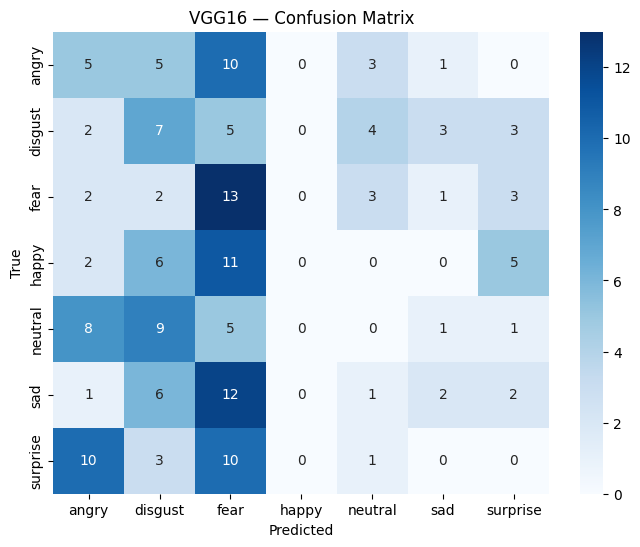


Classification Report:
              precision    recall  f1-score   support

       angry       0.17      0.21      0.19        24
     disgust       0.18      0.29      0.23        24
        fear       0.20      0.54      0.29        24
       happy       0.00      0.00      0.00        24
     neutral       0.00      0.00      0.00        24
         sad       0.25      0.08      0.12        24
    surprise       0.00      0.00      0.00        24

    accuracy                           0.16       168
   macro avg       0.11      0.16      0.12       168
weighted avg       0.11      0.16      0.12       168


Confusion Matrix → ResNet50
Found 168 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src

21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


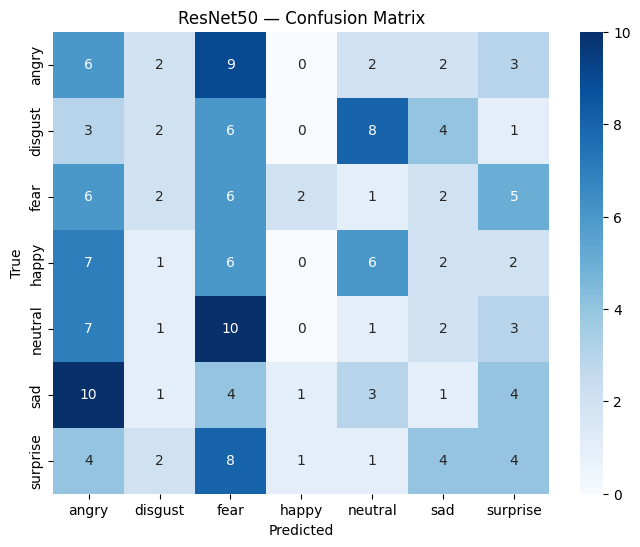


Classification Report:
              precision    recall  f1-score   support

       angry       0.14      0.25      0.18        24
     disgust       0.18      0.08      0.11        24
        fear       0.12      0.25      0.16        24
       happy       0.00      0.00      0.00        24
     neutral       0.05      0.04      0.04        24
         sad       0.06      0.04      0.05        24
    surprise       0.18      0.17      0.17        24

    accuracy                           0.12       168
   macro avg       0.10      0.12      0.10       168
weighted avg       0.10      0.12      0.10       168


Confusion Matrix → InceptionV3
Found 168 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


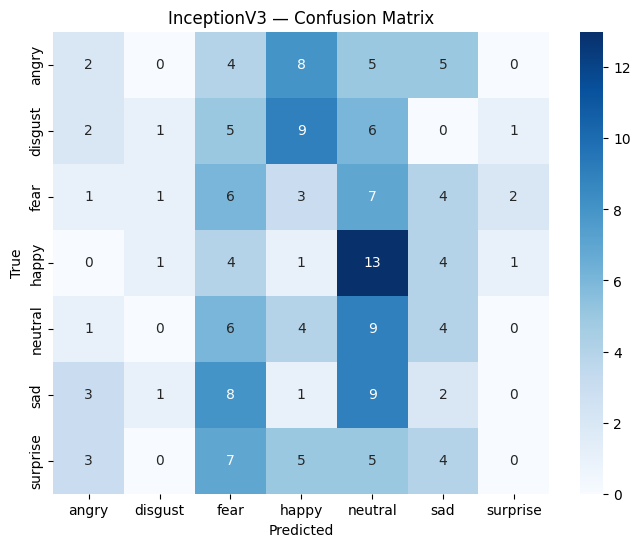


Classification Report:
              precision    recall  f1-score   support

       angry       0.17      0.08      0.11        24
     disgust       0.25      0.04      0.07        24
        fear       0.15      0.25      0.19        24
       happy       0.03      0.04      0.04        24
     neutral       0.17      0.38      0.23        24
         sad       0.09      0.08      0.09        24
    surprise       0.00      0.00      0.00        24

    accuracy                           0.12       168
   macro avg       0.12      0.13      0.10       168
weighted avg       0.12      0.12      0.10       168


Confusion Matrix → EfficientNetB0
Found 168 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step


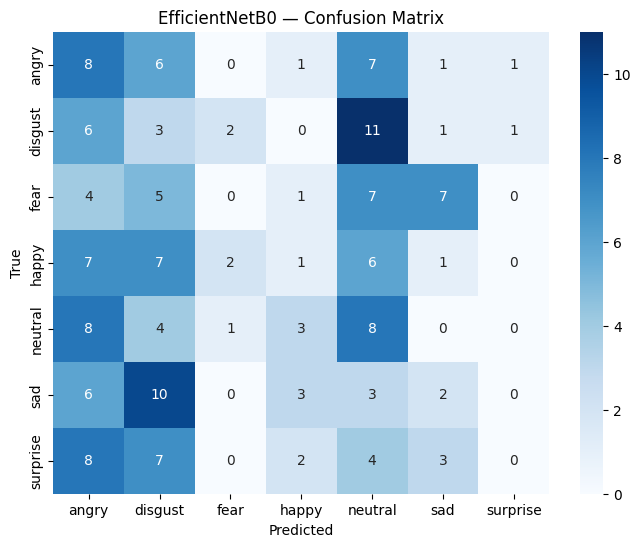


Classification Report:
              precision    recall  f1-score   support

       angry       0.17      0.33      0.23        24
     disgust       0.07      0.12      0.09        24
        fear       0.00      0.00      0.00        24
       happy       0.09      0.04      0.06        24
     neutral       0.17      0.33      0.23        24
         sad       0.13      0.08      0.10        24
    surprise       0.00      0.00      0.00        24

    accuracy                           0.13       168
   macro avg       0.09      0.13      0.10       168
weighted avg       0.09      0.13      0.10       168



In [5]:
import os
import numpy as np
import pickle
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Added this import
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, EfficientNetB0
)
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

# Directory where saved models exist
save_dir = Path("/content/drive/MyDrive/EmotionDetection_Trained")
val_dir = Path("/content/drive/MyDrive/24_images/test")

# Re-define MODEL_SPECS to ensure it's available
MODEL_SPECS = {
    "VGG16": {"base": VGG16, "target_hw": (224, 224), "preprocess": vgg_preprocess},
    "ResNet50": {"base": ResNet50, "target_hw": (224, 224), "preprocess": resnet_preprocess},
    "InceptionV3": {"base": InceptionV3, "target_hw": (299, 299), "preprocess": inception_preprocess},
    "EfficientNetB0": {"base": EfficientNetB0, "target_hw": (224, 224), "preprocess": effnet_preprocess},
}

MODEL_SPECS_REDUCED = {
    "VGG16": MODEL_SPECS["VGG16"],
    "ResNet50": MODEL_SPECS["ResNet50"],
    "InceptionV3": MODEL_SPECS["InceptionV3"],
    "EfficientNetB0": MODEL_SPECS["EfficientNetB0"]
}

BATCH_SIZE = 8

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

for name, spec in MODEL_SPECS_REDUCED.items():
    print(f"\n==============================")
    print(f"Confusion Matrix → {name}")
    print(f"==============================")

    target_h, target_w = spec["target_hw"]
    preprocess_fn = spec["preprocess"]

    # Load validation set
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    val_data = val_datagen.flow_from_directory(
        val_dir,
        target_size=(target_h, target_w),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    # Load model & metadata
    model_path = save_dir / f"{name}_emotion_model.keras"
    meta_path = save_dir / f"{name}_metadata.pkl"

    model = tf.keras.models.load_model(model_path, compile=False)
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)

    labels = meta["emotion_labels"]

    # Predictions
    preds = model.predict(val_data, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels, f"{name} — Confusion Matrix")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))